## Import Libraries

In [2]:
%pip install emojis
%pip install tqdm

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import emojis
from keras.preprocessing.text import Tokenizer
import nltk
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import re
import matplotlib.pyplot as plt

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
tqdm.pandas(desc="Progress: ")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Loading DATASET


In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/NLP/Project/tweetset.csv', encoding="windows-1254")

In [ ]:
df1.head(5)

,Tip,Paylaşım,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,Negatif,Doğa ağzımıza sıçsa hakkı var,NaN,NaN,NaN,NaN
1,Pozitif,"Anne bir sanatçıdır, en güzel eseri de yavrusu...",NaN,NaN,NaN,NaN
2,Negatif,ibrahimin oğlunu koruyan Tanrı’ya da ben sokayım,NaN,NaN,NaN,NaN
3,Negatif,Köpeğim suratına sıçsın senin namussuz karı,NaN,NaN,NaN,NaN
4,Negatif,"Ben söğüşledim, birazda sen söğüşle",NaN,NaN,NaN,NaN


In [ ]:
df1 = df1.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4','Unnamed: 5'], axis = 1 )

In [ ]:
df1.isnull().sum()

Tip         0
Paylaşım    0
dtype: int64

In [ ]:
df1.shape

(11111, 2)

In [ ]:
df2 = pd.read_csv('/content/drive/MyDrive/NLP/Project/TurkishTweets.csv', encoding='utf-8')

In [ ]:
df2.head(5)

,Tweet,Etiket
0,Allah'ım çıldıracağım. Yemin ederim çıldıracağ...,kızgın
1,site ne zaman çalıştıda ürün stokları bitti di...,kızgın
2,Sebebi neydi ki diye bağıracağım şimdi az kaldı,kızgın
3,Black friday ne amk bu yıl çıkardınız bu bokud...,kızgın
4,kısa kısa cevaplar vericeksen niye yazıyorsun ...,kızgın


In [ ]:
df2.isnull().sum()

Tweet     1
Etiket    0
dtype: int64

In [ ]:
df2 = df2.dropna()
df2.isnull().sum()

Tweet     0
Etiket    0
dtype: int64

## Change labels in datasets

In [ ]:
df2['Etiket'].unique()

array(['kızgın', 'korku', 'mutlu', 'surpriz', 'üzgün'], dtype=object)

In [ ]:
df2["Etiket"].replace({"kızgın": "Negative", "korku": "Negative", "mutlu": "Positive",
                        "surpriz": "Positive", "üzgün": "Negative"}, inplace=True)
df2['Etiket'].unique()

array(['Negative', 'Positive'], dtype=object)

In [ ]:
df2.columns = ['content','sentiment']
df2.head(5)

,content,sentiment
0,Allah'ım çıldıracağım. Yemin ederim çıldıracağ...,Negative
1,site ne zaman çalıştıda ürün stokları bitti di...,Negative
2,Sebebi neydi ki diye bağıracağım şimdi az kaldı,Negative
3,Black friday ne amk bu yıl çıkardınız bu bokud...,Negative
4,kısa kısa cevaplar vericeksen niye yazıyorsun ...,Negative


In [ ]:
df1['Tip'].replace({'Pozitif': 'Positive', 'Negatif': 'Negative', ' Negatif':'Negative'}, inplace=True)
df1['Tip'].unique()


array(['Negative', 'Positive'], dtype=object)

In [ ]:
df1.columns = ['sentiment','content']
df1.head(5)

,sentiment,content
0,Negative,Doğa ağzımıza sıçsa hakkı var
1,Positive,"Anne bir sanatçıdır, en güzel eseri de yavrusu..."
2,Negative,ibrahimin oğlunu koruyan Tanrı’ya da ben sokayım
3,Negative,Köpeğim suratına sıçsın senin namussuz karı
4,Negative,"Ben söğüşledim, birazda sen söğüşle"


In [ ]:
df1 = df1.reindex(columns=['content','sentiment'])
df1.head(5)

,content,sentiment
0,Doğa ağzımıza sıçsa hakkı var,Negative
1,"Anne bir sanatçıdır, en güzel eseri de yavrusu...",Positive
2,ibrahimin oğlunu koruyan Tanrı’ya da ben sokayım,Negative
3,Köpeğim suratına sıçsın senin namussuz karı,Negative
4,"Ben söğüşledim, birazda sen söğüşle",Negative


## Concatenate datasets

In [ ]:
df = pd.concat([df1,df2], ignore_index=True)
df.head(5)

,content,sentiment
0,Doğa ağzımıza sıçsa hakkı var,Negative
1,"Anne bir sanatçıdır, en güzel eseri de yavrusu...",Positive
2,ibrahimin oğlunu koruyan Tanrı’ya da ben sokayım,Negative
3,Köpeğim suratına sıçsın senin namussuz karı,Negative
4,"Ben söğüşledim, birazda sen söğüşle",Negative


In [ ]:
df.shape

(15110, 2)

## Pre-processing Dataset

In [ ]:
def remove_stop_words(text):
    stop_words = set(stopwords.words("turkish"))
    text = text.split()
    return " ".join([word for word in text if word not in stop_words])

def lower_case(text):
    return text.lower()

def remove_emojis(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def decode_emojis(text):
    return emojis.decode(text)

def remove_punctuation(text):
    return re.sub(r'[^\w\s]','',text)

def remove_emails(text):
    return re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)', '', text)  # Remove emails

def remove_urls(text):
    return re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '', text)  # Remove URLs


In [ ]:
df['preprocessed_content'] = df.content.fillna('').progress_apply(remove_stop_words)
df.preprocessed_content = df.preprocessed_content.progress_apply(decode_emojis)
df.preprocessed_content = df.preprocessed_content.progress_apply(remove_punctuation)
df.preprocessed_content = df.preprocessed_content.progress_apply(remove_emails)
df.preprocessed_content = df.preprocessed_content.progress_apply(remove_urls)
df.preprocessed_content = df.preprocessed_content.progress_apply(lower_case)
display(df)


Progress: 100%|██████████| 15110/15110 [00:00<00:00, 140436.88it/s]


,content,sentiment,preprocessed_content
0,Doğa ağzımıza sıçsa hakkı var,Negative,doğa ağzımıza sıçsa hakkı var
1,"Anne bir sanatçıdır, en güzel eseri de yavrusu...",Positive,anne bir sanatçıdır güzel eseri yavrusudur
2,ibrahimin oğlunu koruyan Tanrı’ya da ben sokayım,Negative,ibrahimin oğlunu koruyan tanrıya ben sokayım
3,Köpeğim suratına sıçsın senin namussuz karı,Negative,köpeğim suratına sıçsın senin namussuz karı
4,"Ben söğüşledim, birazda sen söğüşle",Negative,ben söğüşledim birazda sen söğüşle
...,...,...,...
15105,Aynı şeyleri yapmaktan sıkıldım,Negative,aynı şeyleri yapmaktan sıkıldım
15106,"Olacağı varsa oluyor ya hani, biteceği varsa d...",Negative,olacağı varsa oluyor hani biteceği varsa bitsi...
15107,Çok şey istiyorum ama sonu hep fiyasko MUTSUZUM,Negative,çok istiyorum sonu fiyasko mutsuzum
15108,Garip bir şekilde canım çok yanıyor moralim bozuk,Negative,garip bir şekilde canım yanıyor moralim bozuk


In [ ]:
stopwords.words('turkish')

['acaba',
 'ama',
 'aslında',
 'az',
 'bazı',
 'belki',
 'biri',
 'birkaç',
 'birşey',
 'biz',
 'bu',
 'çok',
 'çünkü',
 'da',
 'daha',
 'de',
 'defa',
 'diye',
 'eğer',
 'en',
 'gibi',
 'hem',
 'hep',
 'hepsi',
 'her',
 'hiç',
 'için',
 'ile',
 'ise',
 'kez',
 'ki',
 'kim',
 'mı',
 'mu',
 'mü',
 'nasıl',
 'ne',
 'neden',
 'nerde',
 'nerede',
 'nereye',
 'niçin',
 'niye',
 'o',
 'sanki',
 'şey',
 'siz',
 'şu',
 'tüm',
 've',
 'veya',
 'ya',
 'yani']

In [ ]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

nltk.download('stopwords')
nltk.download('punkt')

def text_normalization(text):
    # Remove diacritics
    text = re.sub(r'[^\x00-\x7F]+', '', text)

    # Convert to lowercase
    text = text.lower()

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('turkish'))
    tokens = [word for word in tokens if word not in stop_words]

    # Stemming
    # stemmer = SnowballStemmer('turkish')
    # tokens = [stemmer.stem(word) for word in tokens]

    # Rejoin tokens into normalized text
    normalized_text = ' '.join(tokens)

    return normalized_text

# Example usage
original_text = "Türkçe metnı normalize etmek istiyorum!"
normalized_text = text_normalization(original_text)
print(normalized_text)


trke metn normalize etmek istiyorum


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
%pip install zemberek-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.1/95.1 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 13.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141211 sha256=7dc0891a72c020bd62cfb1b0ab0d1e3ce31e0a864b5a2518dc815440db30bc5f
  Stored in directory: /root/.cache/pip/wheels/a7/20/bd/e1477d664f22d99989fd28ee1a43d6633dddb5cb9e801350d5
Successfully built antlr4-python3-runtime


In [ ]:
from zemberek import TurkishSentenceNormalizer

normalizer = TurkishSentenceNormalizer(morphology)

def normalize_long_text(text):
    sentences = extractor.from_paragraph(text)
    normalized_sentences = [normalizer.normalize(sentence) for sentence in sentences]
    normalized_text = " ".join(normalized_sentences)
    return normalized_text

df['normalized_content'] = df.preprocessed_content.progress_apply(normalize_long_text)


Progress: 100%|██████████| 15110/15110 [1:17:55<00:00,  3.23it/s]


In [ ]:
df.to_csv('/content/drive/MyDrive/NLP/Project/normalized_dataset_tr.csv',sep='\t' ,encoding='utf-8')

In [ ]:
display(df)

,content,sentiment,preprocessed_content,normalized_content
0,Doğa ağzımıza sıçsa hakkı var,Negative,doğa ağzımıza sıçsa hakkı var,doğa ağzımıza sıçsa hakkı var
1,"Anne bir sanatçıdır, en güzel eseri de yavrusu...",Positive,anne bir sanatçıdır güzel eseri yavrusudur,anne bir sanatçıdır güzel eseri yavrusudur
2,ibrahimin oğlunu koruyan Tanrı’ya da ben sokayım,Negative,ibrahimin oğlunu koruyan tanrıya ben sokayım,ibrahimin oğlunu koruyan tanrıya ben sokayım
3,Köpeğim suratına sıçsın senin namussuz karı,Negative,köpeğim suratına sıçsın senin namussuz karı,köpeğim suratına sıçsın senin namussuz karı
4,"Ben söğüşledim, birazda sen söğüşle",Negative,ben söğüşledim birazda sen söğüşle,ben söğüşledim birazda sen söğüşle
...,...,...,...,...
15105,Aynı şeyleri yapmaktan sıkıldım,Negative,aynı şeyleri yapmaktan sıkıldım,aynı şeyleri yapmaktan sıkıldım
15106,"Olacağı varsa oluyor ya hani, biteceği varsa d...",Negative,olacağı varsa oluyor hani biteceği varsa bitsi...,olacağı varsa oluyor hani biteceği varsa bitsi...
15107,Çok şey istiyorum ama sonu hep fiyasko MUTSUZUM,Negative,çok istiyorum sonu fiyasko mutsuzum,çok istiyorum sonu fiyasko mutsuzum
15108,Garip bir şekilde canım çok yanıyor moralim bozuk,Negative,garip bir şekilde canım yanıyor moralim bozuk,garip bir şekilde canım yanıyor moralim bozuk


## Data Visualization

In [4]:
df = pd.read_csv('/content/drive/MyDrive/NLP/Project/normalized_dataset_tr.csv',sep='\t' ,encoding='utf-8')

In [ ]:
df.head()

,Unnamed: 0,content,sentiment,preprocessed_content,normalized_content
0,0,Doğa ağzımıza sıçsa hakkı var,Negative,doğa ağzımıza sıçsa hakkı var,doğa ağzımıza sıçsa hakkı var
1,1,"Anne bir sanatçıdır, en güzel eseri de yavrusu...",Positive,anne bir sanatçıdır güzel eseri yavrusudur,anne bir sanatçıdır güzel eseri yavrusudur
2,2,ibrahimin oğlunu koruyan Tanrı’ya da ben sokayım,Negative,ibrahimin oğlunu koruyan tanrıya ben sokayım,ibrahimin oğlunu koruyan tanrıya ben sokayım
3,3,Köpeğim suratına sıçsın senin namussuz karı,Negative,köpeğim suratına sıçsın senin namussuz karı,köpeğim suratına sıçsın senin namussuz karı
4,4,"Ben söğüşledim, birazda sen söğüşle",Negative,ben söğüşledim birazda sen söğüşle,ben söğüşledim birazda sen söğüşle


## Data Visualization

In [ ]:
tweet_list = df['content']
negative_list = df[df['sentiment'] == "Negative"]
positive_list = df[df['sentiment'] == "Positive"]

print("total number: ",len(tweet_list))
print("positive number: ",len(positive_list))
print("negative number: ", len(negative_list))

print()

print("% of positive: ",100*len(positive_list)/len(tweet_list))
print("% of negative: ",100*len(negative_list)/len(tweet_list))

total number:  15110
positive number:  7711
negative number:  7399

% of positive:  51.032428855062875
% of negative:  48.967571144937125


In [ ]:
positive = int(100*len(positive_list)/len(tweet_list))
negative = int(100*len(negative_list)/len(tweet_list))

labels = ['Positive ['+str(positive)+'%]','Negative ['+str(negative)+'%]']
sizes = [positive, negative]
colors = ['green', 'red']
patches, texts = plt.pie(sizes,colors=colors, startangle=90, radius=50)
plt.style.use('default')
plt.legend(labels)
plt.title("Sentiment Analysis Result")
plt.axis("equal")
plt.show()

NameError: name 'positive_list' is not defined

### Visualizing Top Words

The distribution of top unigrams after removing stop words.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [ ]:
common_words = get_top_n_words(df['content'], 20)
common_df = pd.DataFrame(common_words, columns = ['content', 'count'])
common_df.head()

,content,count
0,bir,2830
1,bu,2233
2,ve,1535
3,çok,1499
4,ne,1143


<Axes: title={'center': 'Bar Chart of Top Words Frequency'}, xlabel='Top Words', ylabel='Count'>

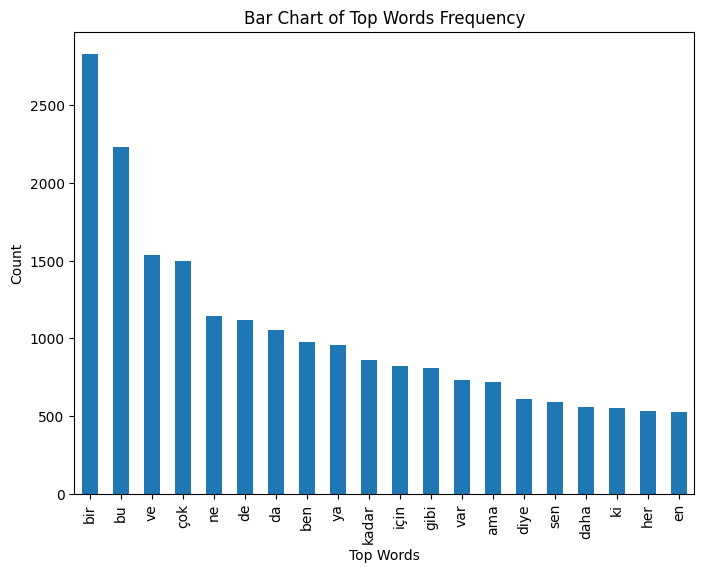

In [ ]:
common_df.groupby('content').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',
    figsize=(8, 6),
    xlabel = "Top Words",
    ylabel = "Count",
    title = "Bar Chart of Top Words Frequency")

## Visualizing N-Grams

#Top Bigrams

In [ ]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2,2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words2 = get_top_n_bigram(df['content'], 30)

In [ ]:
top_bigram = pd.DataFrame(common_words2, columns=['Tweets', "Count"])
top_bigram.head()

,Tweets,Count
0,bu kadar,233
1,şu an,144
2,bir şey,130
3,ne kadar,112
4,orospu çocuğu,105


<Axes: title={'center': 'Bar chart of Bigrams Frequency'}, xlabel='Bigram Words', ylabel='Count'>

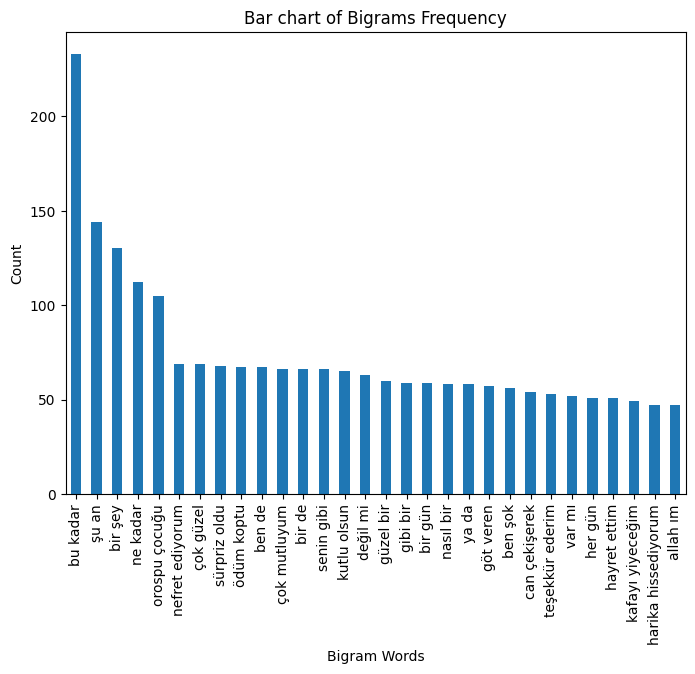

In [ ]:
top_bigram.groupby('Tweets').sum()['Count'].sort_values(ascending=False).plot(
    kind='bar',
    figsize=(8,6),
    xlabel = "Bigram Words",
    ylabel = "Count",
    title = "Bar chart of Bigrams Frequency")

### Top Trigrams

In [ ]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words3 = get_top_n_trigram(df['content'], 30)
top_trigram = pd.DataFrame(common_words3, columns = ['content' , 'Count'])
top_trigram.head(5)

,content,Count
0,günün kutlu olsun,22
1,yok artık inanmam,22
2,şu an çok,20
3,neden bu kadar,20
4,allah belanı versin,19


<Axes: title={'center': 'Bar chart of Trigrams Frequency'}, xlabel='Trigram Words', ylabel='Count'>

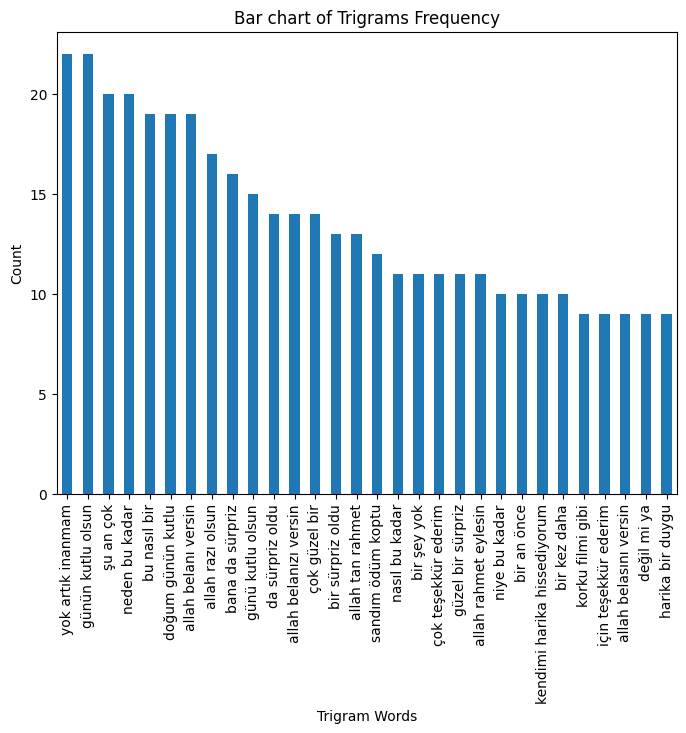

In [ ]:
top_trigram.groupby('content').sum()['Count'].sort_values(ascending=False).plot(
    kind='bar',
    figsize=(8,6),
    xlabel = "Trigram Words",
    ylabel = "Count",
    title = "Bar chart of Trigrams Frequency")

In [ ]:
from wordcloud import WordCloud, STOPWORDS

def creat_wordcloud(tweets):
    comment_words = ''
    stopwords = set(STOPWORDS)

    # iterate through the csv file
    for val in tweets:

        # typecaste each val to string
        val = str(val)

        # split the value
        tokens = val.split()

        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()

        comment_words += " ".join(tokens)+" "

    wordcloud = WordCloud(width = 1200, height = 800,
                    background_color ='white',
                    max_words=3000,
                    stopwords = stopwords,
                    min_font_size = 10,
                    repeat = True).generate(comment_words)

    # plot the WordCloud image
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)

    plt.show()

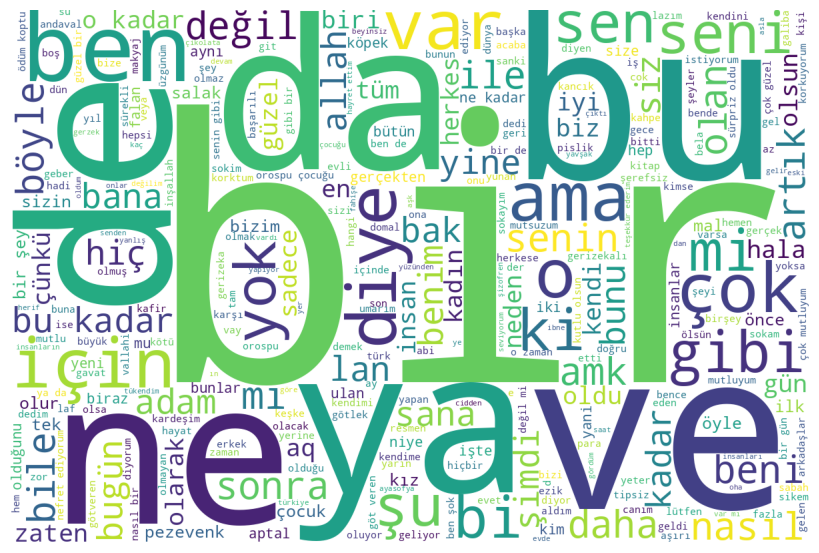

In [ ]:
# All Tweets
creat_wordcloud(df['content'].values)

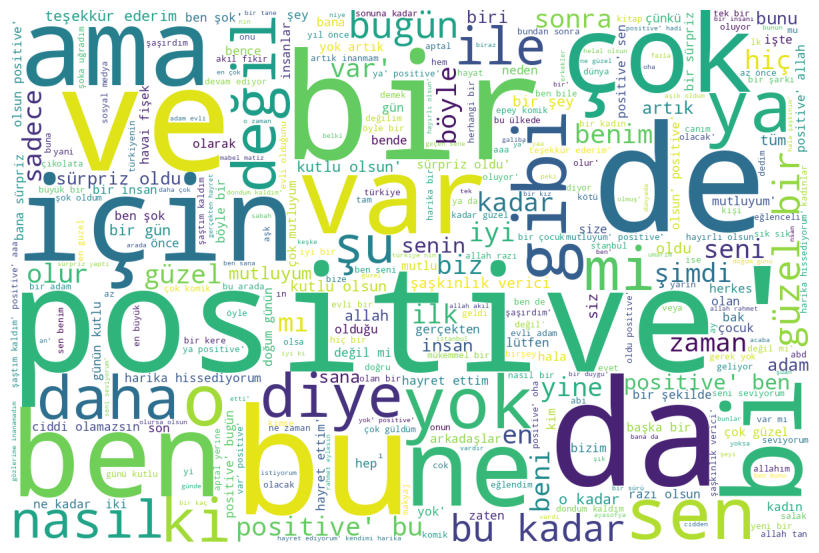

In [ ]:
# Positive Tweets
creat_wordcloud(df[df['sentiment'] == 'Positive'].values)

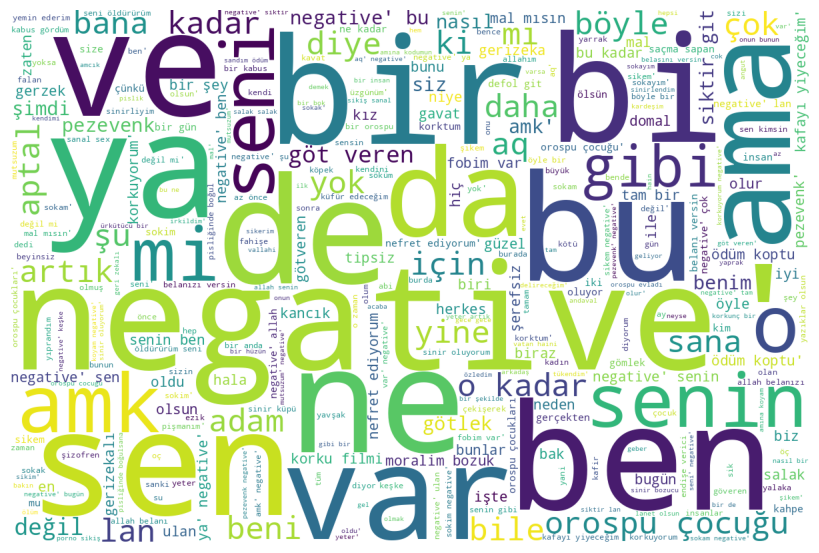

In [ ]:
# Negative Tweets
creat_wordcloud(df[df['sentiment'] == 'Negative'].values)

## Word Embeddings

In [7]:
import collections

# Packages for data preparation
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences

# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers

In [8]:
NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
VAL_SIZE = 1000  # Size of the validation set
NB_START_EPOCHS = 20  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent
MAX_LEN = 24  # Maximum number of words in a sequence
GLOVE_DIM = 50  # Number of dimensions of the GloVe word embeddings

In [9]:
def deep_model(model, X_train, y_train, X_valid, y_valid):
    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])

    history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=1)
    return history

def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test, y_test)
    return results

In [14]:
df.dropna(subset=['normalized_content'])

,Unnamed: 0,content,sentiment,preprocessed_content,normalized_content
0,0,Doğa ağzımıza sıçsa hakkı var,Negative,doğa ağzımıza sıçsa hakkı var,doğa ağzımıza sıçsa hakkı var
1,1,"Anne bir sanatçıdır, en güzel eseri de yavrusu...",Positive,anne bir sanatçıdır güzel eseri yavrusudur,anne bir sanatçıdır güzel eseri yavrusudur
2,2,ibrahimin oğlunu koruyan Tanrı’ya da ben sokayım,Negative,ibrahimin oğlunu koruyan tanrıya ben sokayım,ibrahimin oğlunu koruyan tanrıya ben sokayım
3,3,Köpeğim suratına sıçsın senin namussuz karı,Negative,köpeğim suratına sıçsın senin namussuz karı,köpeğim suratına sıçsın senin namussuz karı
4,4,"Ben söğüşledim, birazda sen söğüşle",Negative,ben söğüşledim birazda sen söğüşle,ben söğüşledim birazda sen söğüşle
...,...,...,...,...,...
15105,15105,Aynı şeyleri yapmaktan sıkıldım,Negative,aynı şeyleri yapmaktan sıkıldım,aynı şeyleri yapmaktan sıkıldım
15106,15106,"Olacağı varsa oluyor ya hani, biteceği varsa d...",Negative,olacağı varsa oluyor hani biteceği varsa bitsi...,olacağı varsa oluyor hani biteceği varsa bitsi...
15107,15107,Çok şey istiyorum ama sonu hep fiyasko MUTSUZUM,Negative,çok istiyorum sonu fiyasko mutsuzum,çok istiyorum sonu fiyasko mutsuzum
15108,15108,Garip bir şekilde canım çok yanıyor moralim bozuk,Negative,garip bir şekilde canım yanıyor moralim bozuk,garip bir şekilde canım yanıyor moralim bozuk


In [18]:
float_values = df[df['normalized_content'].apply(lambda x: isinstance(x, float))]

print("Float values in 'normalized_content':")
print(float_values)
df = df[~df['normalized_content'].apply(lambda x: isinstance(x, float))]

print("DataFrame after removing rows with float values:")
print(df)

Float values in 'normalized_content':
       Unnamed: 0 content sentiment preprocessed_content normalized_content
11208       11208          Negative                  NaN                NaN
DataFrame after removing rows with float values:
       Unnamed: 0                                            content  \
0               0                      Doğa ağzımıza sıçsa hakkı var   
1               1  Anne bir sanatçıdır, en güzel eseri de yavrusu...   
2               2   ibrahimin oğlunu koruyan Tanrı’ya da ben sokayım   
3               3        Köpeğim suratına sıçsın senin namussuz karı   
4               4                Ben söğüşledim, birazda sen söğüşle   
...           ...                                                ...   
15105       15105                    Aynı şeyleri yapmaktan sıkıldım   
15106       15106  Olacağı varsa oluyor ya hani, biteceği varsa d...   
15107       15107    Çok şey istiyorum ama sonu hep fiyasko MUTSUZUM   
15108       15108  Garip bir şekilde canı

In [19]:
X_train, X_test, y_train, y_test = train_test_split(df.normalized_content, df.sentiment, test_size=0.2, random_state=42)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 12087
# Test data samples: 3022


In [20]:
tk = Tokenizer(num_words=NB_WORDS)
tk.fit_on_texts(X_train)

X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

In [21]:
seq_lengths = X_train.apply(lambda x: len(x.split(' ')))
seq_lengths.describe()

count    12087.000000
mean         9.746670
std          6.574465
min          1.000000
25%          5.000000
50%          8.000000
75%         12.000000
max         64.000000
Name: normalized_content, dtype: float64

In [22]:
X_train_seq_trunc = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_seq_trunc = pad_sequences(X_test_seq, maxlen=MAX_LEN)

In [23]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

In [24]:
X_train_emb, X_valid_emb, y_train_emb, y_valid_emb = train_test_split(X_train_seq_trunc, y_train_oh, test_size=0.1, random_state=37)

assert X_valid_emb.shape[0] == y_valid_emb.shape[0]
assert X_train_emb.shape[0] == y_train_emb.shape[0]

print('Shape of validation set:',X_valid_emb.shape)

Shape of validation set: (1209, 24)


In [25]:
emb_model = models.Sequential()
emb_model.add(layers.Embedding(NB_WORDS, 8, input_length=MAX_LEN))
emb_model.add(layers.Flatten())
emb_model.add(layers.Dense(2, activation='softmax'))
emb_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 24, 8)             80000     
                                                                 
 flatten (Flatten)           (None, 192)               0         
                                                                 
 dense (Dense)               (None, 2)                 386       
                                                                 
Total params: 80386 (314.01 KB)
Trainable params: 80386 (314.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
emb_history = deep_model(emb_model, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)

Epoch 1/20
22/22 [==============================] - 8s 82ms/step - loss: 0.6923 - accuracy: 0.5214 - val_loss: 0.6904 - val_accuracy: 0.5385
Epoch 2/20
22/22 [==============================] - 0s 9ms/step - loss: 0.6877 - accuracy: 0.5735 - val_loss: 0.6861 - val_accuracy: 0.5964
Epoch 3/20
22/22 [==============================] - 0s 7ms/step - loss: 0.6808 - accuracy: 0.6241 - val_loss: 0.6797 - val_accuracy: 0.6088
Epoch 4/20
22/22 [==============================] - 1s 47ms/step - loss: 0.6704 - accuracy: 0.6764 - val_loss: 0.6691 - val_accuracy: 0.6725
Epoch 5/20
22/22 [==============================] - 1s 45ms/step - loss: 0.6557 - accuracy: 0.7244 - val_loss: 0.6552 - val_accuracy: 0.7188
Epoch 6/20
22/22 [==============================] - 1s 49ms/step - loss: 0.6366 - accuracy: 0.7666 - val_loss: 0.6378 - val_accuracy: 0.7543
Epoch 7/20
22/22 [==============================] - 0s 11ms/step - loss: 0.6134 - accuracy: 0.8127 - val_loss: 0.6173 - val_accuracy: 0.7825
Epoch 8/20
22/2

In [27]:
def eval_metric(history, metric_name):
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

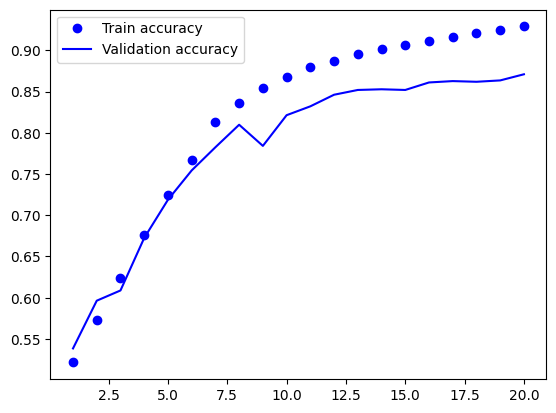

In [30]:
eval_metric(emb_history, 'accuracy')

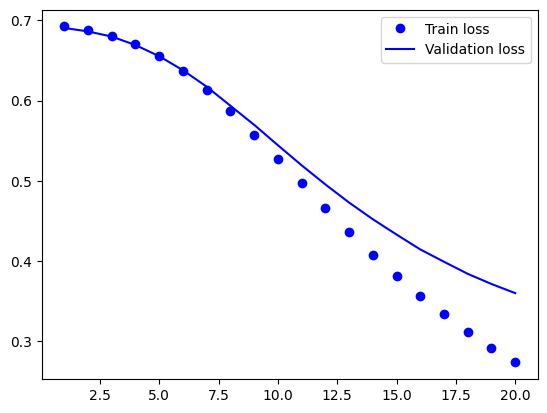

In [31]:
eval_metric(emb_history, 'loss')

In [32]:
emb_results = test_model(emb_model, X_train_seq_trunc, y_train_oh, X_test_seq_trunc, y_test_oh, 6)
print('/n')
print('Test accuracy of word embeddings model: {0:.2f}%'.format(emb_results[1]*100))

95/95 [==============================] - 2s 24ms/step - loss: 0.3329 - accuracy: 0.8607
/n
Test accuracy of word embeddings model: 86.07%


## Pretrained word embedding glove

In [33]:
!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip

--2024-05-20 09:18:15--  http://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... failed: Connection timed out.
Retrying.

--2024-05-20 09:20:28--  (try: 2)  http://nlp.stanford.edu/data/glove.twitter.27B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... failed: Connection timed out.
Retrying.

--2024-05-20 09:22:40--  (try: 3)  http://nlp.stanford.edu/data/glove.twitter.27B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... failed: Connection timed out.
Retrying.

--2024-05-20 09:24:52--  (try: 4)  http://nlp.stanford.edu/data/glove.twitter.27B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... failed: Connection timed out.
Retrying.

--2024-05-20 09:27:09--  (try: 5)  http://nlp.stanford.edu/data/glove.twitter.27B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80..

In [34]:
!unzip glove.twitter.27B.zip

unzip:  cannot find or open glove.twitter.27B.zip, glove.twitter.27B.zip.zip or glove.twitter.27B.zip.ZIP.


In [ ]:
import numpy as np

glove_file = 'glove.twitter.27B.' + str(GLOVE_DIM) + 'd.txt'
emb_dict = {}
glove = open(glove_file)
for line in glove:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    emb_dict[word] = vector
glove.close()

In [ ]:
some_words = ['ben', 'koltuk', 'kraliçe', 'masa']
for w in some_words:
    if w in emb_dict.keys():
        print('Found the word {} in the dictionary'.format(w))

In [ ]:
tk = Tokenizer(num_words=NB_WORDS)

In [ ]:
emb_matrix = np.zeros((NB_WORDS, GLOVE_DIM))

for w, i in tk.word_index.items():
    if i < NB_WORDS:
        vect = emb_dict.get(w)
        if vect is not None:
            emb_matrix[i] = vect
    else:
        break

In [ ]:
glove_model = models.Sequential()
glove_model.add(layers.Embedding(NB_WORDS, GLOVE_DIM, input_length=MAX_LEN))
glove_model.add(layers.Flatten())
glove_model.add(layers.Dense(2, activation='softmax'))
glove_model.summary()

In [ ]:
glove_model.layers[0].set_weights([emb_matrix])
glove_model.layers[0].trainable = False

In [ ]:
glove_history = deep_model(glove_model, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)

In [ ]:
eval_metric(glove_history, 'accuracy')

In [ ]:
eval_metric(glove_history, 'loss')

In [ ]:
glove_results = test_model(glove_model, X_train_seq_trunc, y_train_oh, X_test_seq_trunc, y_test_oh, 3)
print('/n')
print('Test accuracy of word glove model: {0:.2f}%'.format(glove_results[1]*100))